# Definición de parámetros y funciones

In [6]:
import random
import numpy
from itertools import product
import copy
import statistics
import matplotlib.pyplot as plt
import scipy.special
import time
# Parámetros del problema
n = 2 # Nº de situaciones anteriores a recordar para tomar la decisión actual
m = 2**(n*2) # NO TOCAR (depende de n). Nº de situaciones anteriores posibles. Coincide con el nº de bits necesarios para representar las estrategias
pagos = [[1,5],[0,3]] # Matriz de pagos, casos 00 01 10 11 de las decisiones
l = 50 # Nº de rondas que se jugarán cada vez que se enfrenten 2 estrategias
r = 0 # Entero entre 0 y n. Número máximo de veces que se puede tomar la decisión '0' seguidas. Factor de limitación.

# Parámetros del algoritmo genético
k = 1000 # Nº máximo de iteraciones del algoritmo
p = 50 # Tamaño de la población inicial
pm = 50 # Tamaño del mercado (población mercado) que servirá para evaluar la población
t = 0.8 # Valor de 0 a 1. Tamaño de la selección de padres y supervivientes tras la evaluación. 
mt = 1 # Probabilidad de mutar

In [2]:
# Funciones auxiliares
def binToDec(x): # Desde una lista de 0s y 1s a decimal
  num = 0
  for a in x:
    num = 2 * num + a
  return num

def binToDecNumber(x): # Directamente un numero binario a decimal
  binary = x
  decimal, i, n = 0, 0, 0
  while(binary != 0):
    dec = binary % 10
    decimal = decimal + dec * pow(2, i)
    binary = binary//10
    i += 1
  return decimal    

def crearJugadasAnteriores():
  jugada = []
  contador = 0
  for i in range(n):
    if r == 0:
      x = random.randint(0,1)
    elif contador == r:
      x = 1
      contador = 0
    else:
      x = random.randint(0,1)
      if x == 0:
        contador += 1
      else:
        contador = 0
    jugada.append(x)  
  return jugada 

In [4]:
# Función de evaluación fija. Para una muestra fija dada de entrada, se buscarán aquellos valores que maximicen los puntos frente a esa entrada
def evaluarFijo(poblacion, mercado):
  resultados = [0] * p # Crear una lista vacía de resultados de tamaño p
  for index,estrategia in enumerate(poblacion):  
    estrategiaA = poblacion[index]
    for subindex,subestrategia in enumerate(mercado):
      estrategiaB = mercado[subindex]
      puntosA = 0
      jugadasAnterioresAuxA = copy.copy(jugadasAnterioresA) # Mantenemos las jugadas iniciales para que todas empiecen en las mismas condiciones
      jugadasAnterioresAuxB = copy.copy(jugadasAnterioresB) # Mantenemos las jugadas iniciales para que todas empiecen en las mismas condiciones
      for i in range(l):
        eleccionA = estrategiaA[binToDec(jugadasAnterioresAuxA)]
        eleccionB = estrategiaB[binToDec(jugadasAnterioresAuxB)]
        cobroA = pagos[eleccionA][eleccionB]
        puntosA += cobroA
        del jugadasAnterioresAuxA[-2:] # Eliminar los dos últimos elementos, aka, la última jugada en el tiempo
        jugadasAnterioresAuxA.insert(0, eleccionB) # Añadimos primero el de B
        jugadasAnterioresAuxA.insert(0, eleccionA) # Ya que A aparecerá primero luego
        del jugadasAnterioresAuxB[-2:] # Desde la perspectiva de B
        jugadasAnterioresAuxB.insert(0, eleccionA)
        jugadasAnterioresAuxB.insert(0, eleccionB)
      resultados[index] += puntosA/l # media de puntos obtenidos en las l jugadas
  return resultados   

In [ ]:
def seleccionarPesos(resultados, poblacion):
  pesos = scipy.special.softmax(resultados)
  indices = [i for i in range(p)]
  seleccionIndices = numpy.random.choice(indices, size=int(t*p), replace=False, p=pesos) # Selección de padres aleatoria en función de pesos sin repetición
  seleccion = [poblacion[i] for i in seleccionIndices]
  return seleccion

In [ ]:
def cruzar(poblacion):
  cruce = []
  if t < 0.5:
    longitud = int(t*p) # Si se selecciona menos del 50% de la población como padres, se genera esa misma cantidad de hijos 
  else:
    longitud = p - int(t*p)  # En caso contrario, sólo se generan los hijos que falten para volver al 100% de tamaño de la población
  for i in range(longitud):
    padre = poblacion[random.randint(0,len(poblacion)-1)]
    madre = poblacion[random.randint(0,len(poblacion)-1)]
    hijo = []
    for a in range(m):
      if random.randint(0,1) == 0: # 50 50 de coger gen del padre o de la madre
        hijo.append(padre[a])
      else:
        hijo.append(madre[a])
    cruce.append(hijo)  
  return cruce    

In [ ]:
def mutar(poblacion):
  mutacion = copy.deepcopy(poblacion) # Para no modificar la población
  indices = list(set([i for i in range(m)]).difference(situaciones_restringidas)) # indices que si podemos mutar
  for i in range(len(poblacion)):
    if random.random() < mt: # Probabilidad de mutar
      indicesaux = copy.copy(indices)
      random.shuffle(indicesaux) # Barajamos índices para seleccionar un bit aleatorio a mutar
      indice = indicesaux.pop()
      mutacion[i][indice] = 1 - mutacion[i][indice] # Cambiar de 0 a 1 o de 1 a 0  
  return mutacion          

In [ ]:
def reemplazarPesos(resultados, poblacion, hijos):
  pesos = scipy.special.softmax(resultados)
  indices = [i for i in range(p)]
  sobrevivenIndices = numpy.random.choice(indices, size=int(t*p), replace=False, p=pesos) # Selección otra vez aleatoria. No tienen por qué ser los padres
  sobreviven = [poblacion[i] for i in sobrevivenIndices]
  nuevaPoblacion = sobreviven + hijos
  if t < 0.5: # Si la selección es menor que el 50%, rellenar el hueco que falte de sobrevivientes+hijos con aleatorios nuevos
    for i in range(p - int(t*p*2)):
      estrategia = [] # Generar una estrategia aleatoria
      for a in range(m):
        if r > 0 and a in situaciones_restringidas: # Estrategia debe respetar la r
          x = 1 
        else:  
          x = random.randint(0,1)
        estrategia.append(x)
      nuevaPoblacion.append(estrategia)
  return nuevaPoblacion

# Comienzo del programa

In [7]:
# Creación de una cadena de índices de la estrategia que deberán ser 1 de acuerdo con la r
situaciones_restringidas = []
if r > 0:
  listaAux = ['x'] * (2*n) # Usamos 'x' de manera arbitraria para representar que ese bit podrá tomar los valores tanto 1 como 0
  for i in range(r):
    listaAux[i*2] = 0

  cadena_string = ''


  for i in listaAux:
    cadena_string += str(i)

  c = cadena_string.count('x')  
  cadena_string = cadena_string.replace('x',"{}")
  for x in product("01",repeat=c):
    situaciones_restringidas.append(binToDecNumber(int(cadena_string.format(*x))))

print('Con esta configuración hay 2 elevado a', (m-len(situaciones_restringidas)))    

Con esta configuración hay 2 elevado a 16


In [ ]:
# Generar una población inicial aleatoria que respete las restricciones
poblacionInicial = []
for i in range(p):
  estrategia = [] # Generar una estrategia aleatoria
  for a in range(m):
    if r > 0 and a in situaciones_restringidas: # Estrategia debe respetar la r
      x = 1 
    else:  
      x = random.randint(0,1)
    estrategia.append(x)
  poblacionInicial.append(estrategia)

In [ ]:
# Generar una población fija aleatoria. Representa el mercado al que se quiere acceder.
poblacionFija = [] # No tiene por qué respetar las restricciones. Sólo se aplica a nuestras estrategias.
for i in range(pm):
  estrategia = [] # Generar una estrategia aleatoria
  for a in range(m):
    x = random.randint(0,1)
    estrategia.append(x)
  poblacionFija.append(estrategia)

In [ ]:
# Generar unas jugadas anteriores aleatorias, respetando las restricciones
jugadasAnterioresA = [] # Jugadas anteriores aleatorias
jugadasAnterioresB = [] # Jugadas anteriores aleatorias
unasJugadas = crearJugadasAnteriores()
otrasJugadas = crearJugadasAnteriores()
# Jugadas anteriores con respecto a cada uno de los dos jugadores
for a,b in zip(unasJugadas, otrasJugadas):
  jugadasAnterioresA.append(a)
  jugadasAnterioresA.append(b)

for a,b in zip(otrasJugadas,unasJugadas):
  jugadasAnterioresB.append(a)
  jugadasAnterioresB.append(b)

In [ ]:
poblacionActual = copy.copy(poblacionInicial)
generacionest8 = []
#medianas1 = []
#medianas21 = []
tiempot8 = []
mejorResultado = 0
mejorMediana = 0
start_time = time.time()
for i in range(k):
  resultados = evaluarFijo(poblacionActual, poblacionFija)
  seleccion = seleccionarPesos(resultados, poblacionActual)
  cruce = cruzar(seleccion)
  mutacion = mutar(cruce)
  nuevaPoblacion = reemplazarPesos(resultados, poblacionActual, mutacion)
  poblacionActual = nuevaPoblacion
  #mediana = statistics.median(resultados)
  #medianas1.append(mediana)
  #if mediana > mejorMediana:
  #  mejorMediana = mediana
  #medianas21.append(mejorMediana)  
  mejorDeLaPoblacion = max(resultados)
  generacionest8.append(mejorDeLaPoblacion)
  tiempot8.append(int(time.time()-start_time))
  print('Iteración',i,'-',mejorDeLaPoblacion, ' - ', len(poblacionActual))
  if mejorDeLaPoblacion > mejorResultado:
    mejorResultado = mejorDeLaPoblacion
 #   i = 0
  #else:
  #  i += 1  
#mejorIndividuo = poblacionActual[resultados.index(mejorResultado)]
#print('ganador:', mejorIndividuo)

Iteración 0 - 122.44  -  50
Iteración 1 - 122.44  -  50
Iteración 2 - 122.44  -  50
Iteración 3 - 122.44  -  50
Iteración 4 - 122.44  -  50
Iteración 5 - 122.44  -  50
Iteración 6 - 122.44  -  50
Iteración 7 - 122.44  -  50
Iteración 8 - 122.44  -  50
Iteración 9 - 122.44  -  50
Iteración 10 - 122.44  -  50
Iteración 11 - 122.44  -  50
Iteración 12 - 122.44  -  50
Iteración 13 - 125.10000000000002  -  50
Iteración 14 - 125.10000000000002  -  50
Iteración 15 - 125.26  -  50
Iteración 16 - 125.26  -  50
Iteración 17 - 125.26  -  50
Iteración 18 - 126.78000000000002  -  50
Iteración 19 - 126.78000000000002  -  50
Iteración 20 - 126.78000000000002  -  50
Iteración 21 - 128.7  -  50
Iteración 22 - 128.7  -  50
Iteración 23 - 128.7  -  50
Iteración 24 - 128.98000000000002  -  50
Iteración 25 - 128.98000000000002  -  50
Iteración 26 - 128.98000000000002  -  50
Iteración 27 - 128.98000000000002  -  50
Iteración 28 - 128.98000000000002  -  50
Iteración 29 - 128.98000000000002  -  50
Iteración 3

Text(0.5, 0, 'Iteraciones')

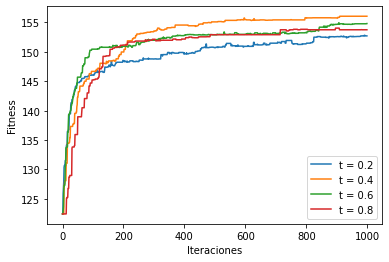

In [ ]:
plt.plot(generacionest2, label='t = 0.2')
plt.plot(generacionest6, label='t = 0.4')
plt.plot(generacionest4, label='t = 0.6')
plt.plot(generacionest8, label='t = 0.8')
plt.legend()
plt.ylabel('Fitness')
plt.xlabel('Iteraciones')

Text(0.5, 0, 'Iteraciones')

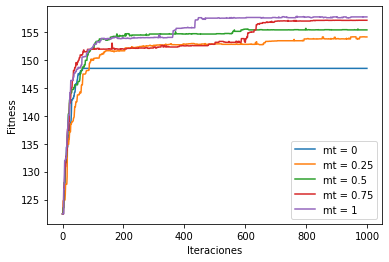

In [ ]:
plt.plot(generacionesm0, label='mt = 0')
plt.plot(generacionesm5, label='mt = 0.25')
plt.plot(generacionesm25, label='mt = 0.5')
plt.plot(generacionesm75, label='mt = 0.75')
plt.plot(generacionesm10, label='mt = 1')
plt.legend()
plt.ylabel('Fitness')
plt.xlabel('Iteraciones')

Text(0.5, 0, 'Iteraciones')

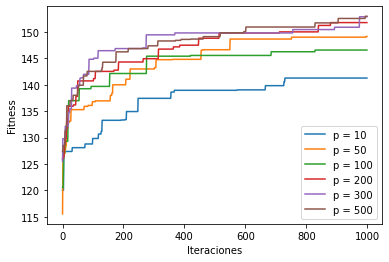

In [ ]:
plt.plot(generaciones10, label='p = 10')
plt.plot(generaciones50, label='p = 50')
plt.plot(generaciones100, label='p = 100')
plt.plot(generaciones200, label='p = 200')
plt.plot(generaciones300, label='p = 300')
plt.plot(generaciones500, label='p = 500')
#plt.plot(generaciones1, label='r = 1')
#plt.plot(medianas2, label='Mediana')
plt.legend()
plt.ylabel('Fitness')
plt.xlabel('Iteraciones')

# Enfriamiento simulado

In [ ]:
# Calculo del fitness igual que en AG pero para un único individuo
def fitness(estrategia, poblacion):
  resultado = 0
  for estrategiaB in poblacion:
    puntosA = 0
    jugadasAnterioresAuxA = copy.copy(jugadasAnterioresA) # Mantenemos las jugadas iniciales para que todas empiecen en las mismas condiciones
    jugadasAnterioresAuxB = copy.copy(jugadasAnterioresB) # Mantenemos las jugadas iniciales para que todas empiecen en las mismas condiciones
    for i in range(l):
      eleccionA = estrategia[binToDec(jugadasAnterioresAuxA)]
      eleccionB = estrategiaB[binToDec(jugadasAnterioresAuxB)]
      cobroA = pagos[eleccionA][eleccionB]
      puntosA += cobroA
      del jugadasAnterioresAuxA[-2:] # Eliminar los dos últimos elementos, aka, la última jugada en el tiempo
      jugadasAnterioresAuxA.insert(0, eleccionB) # Añadimos primero el de B
      jugadasAnterioresAuxA.insert(0, eleccionA) # Ya que A aparecerá primero luego
      del jugadasAnterioresAuxB[-2:] # Desde la perspectiva de B
      jugadasAnterioresAuxB.insert(0, eleccionA)
      jugadasAnterioresAuxB.insert(0, eleccionB)
    resultado += puntosA/l # media de puntos obtenidos en las l jugadas
  return resultado

In [ ]:
def vecino(estrategia, i):
  vecino = copy.copy(estrategia)
  vecino[i] = 1 - vecino[i]
  return vecino

In [ ]:
estrategiaActual = copy.copy(poblacionInicial[0])
estrategiaMejor = copy.copy(estrategiaActual)
generacionesEnfk005 = []
generacionesEnfMk005 = []
temperatura = 1000 # Iniciales, 5, 10, 20, 50. También 1000 hasa 10000
fitnessMejor = fitness(estrategiaMejor, poblacionFija)
vecinosTotales = list(set([i for i in range(m)]).difference(situaciones_restringidas)) # indices que si podemos mutar para obtener vecinos
vecinosRestantes = copy.copy(vecinosTotales)
random.shuffle(vecinosRestantes) # Barajamos índices para seleccionar vecinos aleatorios
i = 0
while vecinosRestantes and i < 10000: # Sigue habiendo vecinos del actual
  i += 1
  estrategiaNueva = vecino(estrategiaActual, vecinosRestantes.pop()) # nuevo sucesor aleatorio (mutacion)
  fitnessNuevo = fitness(estrategiaNueva, poblacionFija)
  fitnessActual = fitness(estrategiaActual, poblacionFija)
  incremento = fitnessNuevo - fitnessActual
  if incremento >= 0: # mejora o iguala la solucion, la aceptamos
    estrategiaActual = estrategiaNueva
    vecinosRestantes = copy.copy(vecinosTotales) # Volvemos a rellenar la lista de vecinos posibles, ya que hemos cambiado de individuo
    random.shuffle(vecinosRestantes)
    if fitnessNuevo > fitnessMejor:
      estrategiaMejor = estrategiaNueva
      fitnessMejor = fitnessNuevo
  else:
    probabilidad = 2.718**(incremento/temperatura) # Típicamente utilizada esta probabilidad
    if random.random() < probabilidad: # Aceptarlo con una probabilidad que depende de la temperatura. Inicialmente, probabilidad debería dar casi 1.
      estrategiaActual = estrategiaNueva 
      #print(probabilidad, temperatura)
      vecinosRestantes = copy.copy(vecinosTotales) # Volvemos a rellenar la lista de vecinos posibles, ya que hemos cambiado de individuo
      random.shuffle(vecinosRestantes)
  temperatura = temperatura/(1+0.05*temperatura) # Probar k muy pequeño. Mejor
  #temperatura = temperatura * 0.99 # k próxima a 1. Lineal
  generacionesEnfk005.append(fitnessActual)
  generacionesEnfMk005.append(fitnessMejor)
  print('Iteración',i,'-',fitnessActual)  

Se han truncado las últimas 5000 líneas del flujo de salida.
Iteración 5001 - 158.7
Iteración 5002 - 158.7
Iteración 5003 - 158.7
Iteración 5004 - 158.7
Iteración 5005 - 158.7
Iteración 5006 - 158.7
Iteración 5007 - 158.7
Iteración 5008 - 158.7
Iteración 5009 - 158.7
Iteración 5010 - 158.7
Iteración 5011 - 158.7
Iteración 5012 - 158.7
Iteración 5013 - 158.7
Iteración 5014 - 158.7
Iteración 5015 - 158.7
Iteración 5016 - 158.7
Iteración 5017 - 158.7
Iteración 5018 - 158.7
Iteración 5019 - 158.7
Iteración 5020 - 158.7
Iteración 5021 - 158.7
Iteración 5022 - 158.7
Iteración 5023 - 158.7
Iteración 5024 - 158.7
Iteración 5025 - 158.7
Iteración 5026 - 158.7
Iteración 5027 - 158.7
Iteración 5028 - 158.7
Iteración 5029 - 158.7
Iteración 5030 - 158.7
Iteración 5031 - 158.7
Iteración 5032 - 158.7
Iteración 5033 - 158.7
Iteración 5034 - 158.7
Iteración 5035 - 158.7
Iteración 5036 - 158.7
Iteración 5037 - 158.7
Iteración 5038 - 158.7
Iteración 5039 - 158.7
Iteración 5040 - 158.7
Iteración 5041 - 15

Text(0.5, 0, 'Iteraciones')

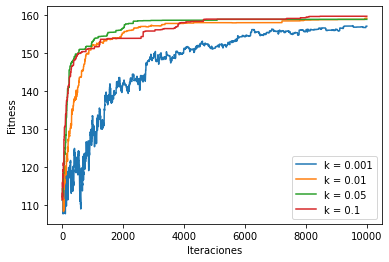

In [ ]:
plt.plot(generacionesEnfk0001, label= 'k = 0.001')
plt.plot(generacionesEnf1000, label= 'k = 0.01')
plt.plot(generacionesEnfk005, label= 'k = 0.05')
plt.plot(generacionesEnfk01, label= 'k = 0.1')
#plt.plot(generacionesEnfk1, label= 'k = 1')
plt.legend()
plt.ylabel('Fitness')
plt.xlabel('Iteraciones')

Text(0.5, 0, 'Iteraciones')

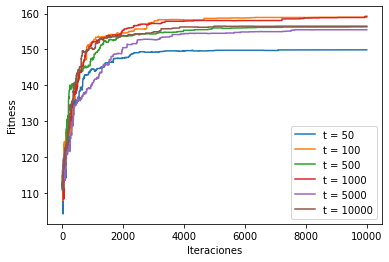

In [ ]:
#plt.plot(generacionesEnfM, label = 't = 5')
plt.plot(generacionesEnf50, label= 't = 50')
plt.plot(generacionesEnf100, label= 't = 100')
plt.plot(generacionesEnf500, label= 't = 500')
plt.plot(generacionesEnf1000, label= 't = 1000')
plt.plot(generacionesEnf5000, label= 't = 5000')
plt.plot(generacionesEnf10000, label= 't = 10000')
plt.legend()
plt.ylabel('Fitness')
plt.xlabel('Iteraciones')

# Mejor de cada uno

Text(0.5, 0, 'Iteraciones')

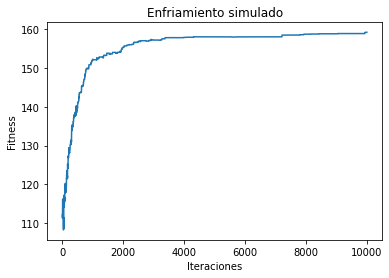

In [ ]:
#plt.plot(generacionesEnfM, label = 't = 5')
plt.plot(generacionesEnf1000)
plt.title('Enfriamiento simulado')
plt.ylabel('Fitness')
plt.xlabel('Iteraciones')

Text(0.5, 0, 'Iteraciones')

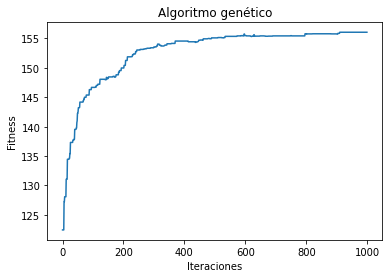

In [ ]:
#plt.plot(generacionesEnfM, label = 't = 5')
plt.plot(generacionest6)
plt.title('Algoritmo genético')
plt.ylabel('Fitness')
plt.xlabel('Iteraciones')